In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
# import earthpy as et
import networkx as nx
from tqdm import tqdm
from scipy import io

import project_path
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
from src.util.t2m import t2m
from src.algos.lr_stss import lr_stss
from dask.distributed import Client, progress, wait
from src.algos.lr_stss_modified import lr_stss_modified
from IPython.display import display, HTML
import optuna
from optuna.integration.dask import DaskStorage

In [3]:
# Load pre-processed Data
cwd = os.getcwd()
data_dir = os.path.join(cwd,'..','data','nyc')

zones = gpd.read_file(os.path.join(data_dir,'taxi_zones_shapefile','taxi_zones.shp'))
zone_lookup = os.path.join(data_dir, 'taxi_zone_lookup.csv')
zone_lookup = pd.read_csv(zone_lookup)

pickups = np.load(os.path.join(data_dir,"hourly_pickup.npy"))
dropoffs = np.load(os.path.join(data_dir,"hourly_dropoff.npy"))
# # Load Emre's settings
dates = io.loadmat(os.path.join(data_dir,'dates.mat'))
regions = io.loadmat(os.path.join(data_dir,'regions.mat'))
neighbors = io.loadmat(os.path.join(data_dir,'neighbors.mat'))
regions=regions['regions'].ravel()

# # Filter the data
pickups = pickups[regions-1, ...]
dropoffs = dropoffs[regions-1, ...]
zones = zones.iloc[regions-1]
dos = np.zeros((81,53,7,24))
dos[:,:52,:,:] = dropoffs
dos[:,52,1:,:] = np.mean(dropoffs[:,:,1:,:],1)
dropoffs = dos.copy()
dos[:,:52,:,:] = pickups
dos[:,52,1:,:] = np.mean(pickups[:,:,1:,:],1)
pickups = dos.copy()
del dos

In [4]:
# Create Graph
pos = np.zeros((81,2))
pos[:,0] = zones.geometry.centroid.x.values
pos[:,1] = zones.geometry.centroid.y.values

position ={}
G_nyc = nx.Graph()
G_nyc.add_nodes_from([(regions[i], {'pos': pos[i,:], 'LocationID': regions[i], 'zone': zones.iloc[i]['zone']}) for i in range(81)])
edge_list =[]
for i in range(len(neighbors['neighbors'].ravel())):
    for neighbor in neighbors['neighbors'].ravel()[i].ravel():
        if np.any(np.isin(neighbor, regions)) and (neighbor!=regions[i]):
            edge_list.append((regions[i], neighbor))
    # edge_list = edge_list + [(regions[i], neighbor) for neighbor in neighbors['neighbors'].ravel()[i]]
    position[regions[i]]=pos[i,:]
G_nyc.add_edges_from(edge_list)
# G_nyc.nodes()
A = nx.adjacency_matrix(G_nyc).toarray()
Deg = np.diag(np.asarray(np.sum(A,axis=1)).ravel())
Dsq = np.linalg.inv(np.sqrt(Deg))
An = Dsq@A@Dsq

In [4]:
# Event detection
def detect_topk_events(anomaly_scores, ratio):
    events_start_ts = pd.to_datetime(['01-Jan-2018', '03-Jan-2018 16:00:00', '14-Jan-2018 09:00:00', '20-Jan-2018 08:00:00', 
                                    '28-Jan-2018 16:00:00', '04-Mar-2018 15:00:00', '31-Mar-2018 13:00:00', '17-Mar-2018 11:00:00',
                                    '20-Mar-2018 10:00:00', '21-Mar-2018 16:00:00', '01-Jul-2018 17:00:00', '04-Jul-2018 17:00:00',
                                    '25-Sep-2018 10:00:00', '04-Oct-2018 08:00:00', '04-Nov-2018 12:00:00', '09-Nov-2018 19:00:00',
                                    '22-Nov-2018 21:00:00', '04-Dec-2018 19:00:00', '16-Dec-2018 10:00:00', '31-Dec-2018 21:00:00'
                                    ])

    events_end_ts = pd.to_datetime(['01-Jan-2018 02:00:00', '03-Jan-2018 22:00:00', '14-Jan-2018 17:00:00', '20-Jan-2018 15:00:00',
                                '28-Jan-2018 23:00:00', '04-Mar-2018 22:00:00', '31-Mar-2018 20:00:00', '17-Mar-2018 17:00:00',
                                '20-Mar-2018 20:00:00', '21-Mar-2018 22:00:00', '01-Jul-2018 22:00:00', '04-Jul-2018 23:00:00',
                                '25-Sep-2018 20:00:00', '04-Oct-2018 15:00:00', '04-Nov-2018 17:00:00', '09-Nov-2018 23:30:00',
                                '22-Nov-2018 23:59:00', '04-Dec-2018 23:59:00', '16-Dec-2018 15:00:00', '31-Dec-2018 23:59:00'
    ])
    indd = np.flip(np.argsort(anomaly_scores, axis=None))
    ind = np.unravel_index(indd[:int(len(indd)*ratio)], anomaly_scores.shape)
    topk_event_idx = ind
    anomaly_mask = np.zeros(anomaly_scores.shape, dtype=bool)
    anomaly_mask[topk_event_idx] =1
    num_detected_events = 0
    idxs = np.arange(81)
    # w = events_start_ts.isocalendar().week
    # d = events_start_ts.day_of_week
    doy = events_start_ts.day_of_year
    w = (doy-1)//(7)
    d = (doy-1) % 7
    h_s = events_start_ts.hour
    h_e = events_end_ts.hour
    for i in range(20):
        event_mask = np.zeros(anomaly_scores.shape, dtype=bool)
        locations = dates['dates'][2].ravel()[i].ravel()
        
        for loc in locations: 
            # event_mask[idxs[regions==loc], w[i]-1, d[i], h_s[i]:h_e[i]] = 1
            # event_mask[idxs[regions==loc], w[i]-1, d[i], h_e[i]] = 1
            event_mask[idxs[regions==loc], w[i], d[i], h_s[i]:h_e[i]] = 1
            event_mask[idxs[regions==loc], w[i], d[i], h_e[i]] = 1
        if np.any(event_mask & anomaly_mask):
            num_detected_events +=1
    return num_detected_events

### Graph Wavelet Kernel

In [5]:
def bp_wavelet_kernel(x, alpha, beta, x2, x1=1):
    g = np.zeros(len(x))

    a1= (alpha*x2 - beta*x1)/(x1*x2*(x1 - x2)*(x1 - x2))
    a2=-(2*alpha*x2**2 - 2*beta*x1**2 + alpha*x1*x2 - beta*x1*x2)/(x1*x2*(x1 - x2)*(x1 - x2))
    a3= (-beta*x1**3 - 2*beta*x1**2*x2 + 2*alpha*x1*x2**2 + alpha*x2**3)/(x1*x2*(x1 - x2)*(x1 - x2))
    a4=(beta*x1**2 - alpha*x2**2 - 2*x1*x2 + x1**2 + x2**2)/(x1**2 - 2*x1*x2 + x2**2)

    g[x<x1] = np.power((x[x<x1]/x1),alpha)

    band = (x>=x1) * ( x<=x2)
    g[band] = a1*np.power(x[band],3) + a2*np.power(x[band],2) + a3*x[band] + a4 
    
    g[x>x2] = np.power(x2/x[x>x2], beta)
    return g

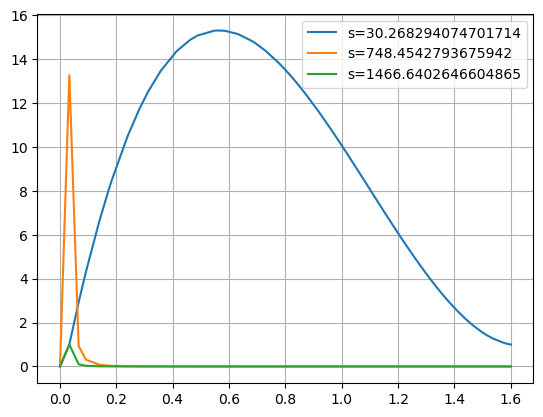

In [7]:
# Generate Wavelet Basis
L = np.eye(An.shape[0]) - An
w, V = np.linalg.eigh(L)
beta = 1/np.log10(w[2]/w[1])
alpha = 2
x1 = 1
x2 = w[-1]/w[1] # 1/w[1]
x=w
# g = bp_wavelet_kernel(x, alpha, beta, x1, x2)

scales = [0.02,0.4,1]+list(np.linspace(x1/w[1], x2/w[1],3))
gs = [bp_wavelet_kernel(s*w, alpha,beta,x2) for s in scales]
[plt.plot(x,g, label=f's={scales[i]}') for i,g in enumerate(gs)]
plt.grid()
plt.legend()
Phis = [V@ np.diag(g) @V.T for g in gs]

In [7]:
psi_params = np.sqrt(np.array([np.trace(np.cov(t2m(dropoffs,i))) for i in [1,2,3,4]]))
psi_dist = psi_params/np.max(psi_params)
print(f"psi distribution:\t {psi_dist}")
print("Tensor dimension:\t",dropoffs.shape)

psi distribution:	 [0.83150206 1.         0.36393466 0.63659289]
Tensor dimension:	 (81, 53, 7, 24)


In [18]:
time_m = 4
local_m = 1
lda_2 = 1000
# psi = 20
# lda_1 = 1
# lda_t = 0.5
# lda_loc = 0.5
# 
# 'psi': 285.73333707777186, 'lda_1': 0.027897553748054003, 'lda_t': 0.011570477860751082, 'lda_l': 8.403725106513411
psi = 285.733; lda_1 = 0.02789; lda_t = 0.01157; lda_loc = 8.4037
resses = []
for phi in Phis:
    res = lr_stss_modified(dropoffs, An, time_m,local_m, verbose=1, max_it=150,
        lda2=lda_2, lda1=lda_1, lda_t=lda_t,
        lda_loc=lda_loc, psis=psi_dist*psi, rho=0.0005, rho_upd=-1, L=phi)
    abs_s = np.abs(res['S'])
    ratios = np.array([0.014, 0.07, 0.14, 0.3, 0.7, 1, 2, 3])/100
    num_detected_events = np.array([detect_topk_events(abs_s, r) for r in ratios])
    print(num_detected_events)
    try:
        resses.append(res)
    except:
        resses = [res]

It-2:	## |r|=314679.75217 	 ## |s|=139761.90080 	 ## rho=0.0005 obj=14533544.8390 	 ## del_obj = 14533538.8994 
It-3:	## |r|=240750.19981 	 ## |s|=218254.30072 	 ## rho=0.0005 obj=53698607.2342 	 ## del_obj = 39165062.3953 
It-4:	## |r|=101047.36160 	 ## |s|=292110.72800 	 ## rho=0.0005 obj=128278696.1262 	 ## del_obj = 74580088.8919 
It-5:	## |r|=92154.33010 	 ## |s|=41451.41776 	 ## rho=0.0005 obj=140121335.7672 	 ## del_obj = 11842639.6411 
It-6:	## |r|=92153.48161 	 ## |s|=4.31368 	 ## rho=0.0005 obj=140120664.6027 	 ## del_obj = -671.1646 
It-7:	## |r|=85487.29642 	 ## |s|=33086.01677 	 ## rho=0.0005 obj=143560167.4043 	 ## del_obj = 3439502.8017 
It-8:	## |r|=85475.60787 	 ## |s|=1356.90290 	 ## rho=0.0005 obj=143700203.5947 	 ## del_obj = 140036.1904 
It-9:	## |r|=82667.72441 	 ## |s|=6212.93411 	 ## rho=0.0005 obj=144828855.2241 	 ## del_obj = 1128651.6294 
It-10:	## |r|=74938.26387 	 ## |s|=34904.23891 	 ## rho=0.0005 obj=151176293.8503 	 ## del_obj = 6347438.6263 
It-11:	## |

In [25]:
i =0
for ress in resses:
    abs_s = np.abs(ress['S'])
    ratios = np.array([0.014, 0.07, 0.14, 0.3, 0.7, 1, 2, 3])/100
    num_detected_events = np.array([detect_topk_events(abs_s, r) for r in ratios])
    
    print(f"scale = {scales[i]}", end='\t\t\t')
    print(num_detected_events)
    i=i+1

scale = 0.02			[ 3  4  6  9 10 14 16 17]
scale = 0.4			[ 3  4  6  9 10 14 16 17]
scale = 1			[ 3  4  6  9 10 14 16 17]
scale = 30.268294074701714			[ 3  4  7 10 11 12 17 17]
scale = 748.4542793675942			[ 3  4  6  8 10 13 16 17]
scale = 1466.6402646604865			[ 3  4  6  9 10 14 16 17]


In [ ]:
fig, axe = plt.subplots(3,1, figsize=(5,10))
for rs in resses:
    axe[0].plot(rs['detected_events']['sum'], label='rho='+str(rs['rho'][0]))
    axe[1].plot(rs['detected_events']['3'], label='rho='+str(rs['rho'][0]))
    axe[2].plot(rs['detected_events']['2'], label='rho='+str(rs['rho'][0]))
for i in range(3):
    axe[i].legend()
    axe[i].set_xlabel('iterations')
    axe[i].set_ylabel('Sum of Detections')


In [26]:
# io.savemat('nyc_taxi_dropoff_with_wavelet2.mat', {'S':np.moveaxis(res['S'],[0,1,2,3],[3,2,1,0])})
io.savemat('nyc_taxi_dropoff_with_wavelet_scales.mat', {'S0':np.moveaxis(resses[0]['S'],[0,1,2,3],[3,2,1,0]),
                                                 'S1':np.moveaxis(resses[1]['S'],[0,1,2,3],[3,2,1,0]),
                                                 'S2':np.moveaxis(resses[2]['S'],[0,1,2,3],[3,2,1,0]),
                                                 'S3':np.moveaxis(resses[3]['S'],[0,1,2,3],[3,2,1,0]),
                                                 'S4':np.moveaxis(resses[4]['S'],[0,1,2,3],[3,2,1,0]),
                                                 'S5':np.moveaxis(resses[5]['S'],[0,1,2,3],[3,2,1,0]),
                                                 'scales': scales})

# Hyperparameter Search with Optuna for Different Models:

In [9]:
import optuna
from optuna.integration.dask import DaskStorage

def save_study(study, fname, key):
    df = study.trials_dataframe(attrs=('value', 'params', 'user_attrs'))
    df.rename({'value':'detected_event_sum'})
    with pd.HDFStore(fname) as storedata:
        storedata.append(key, df)
        storedata.get_storer(key).attrs.metadata=metadata
    print("Study saved:")
    print(f"Best Detected Event Sum: {study.best_value}")
    print(f"Best parameters: {study.best_params}")

In [10]:
n_cores =20
client = Client(n_workers=n_cores+1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 21
Total threads: 21,Total memory: 251.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43639,Workers: 21
Dashboard: http://127.0.0.1:8787/status,Total threads: 21
Started: Just now,Total memory: 251.70 GiB
Comm: tcp://127.0.0.1:42954,Total threads: 1
Dashboard: http://127.0.0.1:45322/status,Memory: 11.99 GiB
Nanny: tcp://127.0.0.1:42634,


## LR_STSS Vanilla HP Search

In [10]:
study = optuna.create_study(direction='maximize', storage=DaskStorage())
cwd = os.getcwd()
fname_lrssts = os.path.join(cwd, 'results','lrstss_nyc_optuna.hdf5')
key = 'vanilla'
tpe_repeat = 10

study = optuna.create_study(direction='maximize', storage=DaskStorage())

def lr_stss_objective(trial):
    lda_2 = trial.suggest_float('lda_2', 1, 1e4, log=True)
    psi = trial.suggest_float('psi', 0.1, 1.5e2, log=True)
    lda_1 = trial.suggest_float('lda_1', 1e-2, 1e2, log=True)
    lda_t = trial.suggest_float('lda_t', 1e-2, 1e2, log=True)
    lda_loc = trial.suggest_float('lda_l', 1e-2, 1e2, log=True)
    rho = 0.0005
    time_m = 4
    local_m = 1

    res = lr_stss_modified(dropoffs, An, time_m,local_m, verbose=0, max_it=200,
        lda2=lda_2, lda1=lda_1, lda_t=lda_t,
        lda_loc=lda_loc, psis=psi_dist*psi, rho=rho, rho_upd=-1)
    abs_s = np.abs(res['S'])
    ratios = np.array([0.014, 0.07, 0.14, 0.3, 0.7, 1, 2, 3])/100
    num_detected_events = np.array([detect_topk_events(abs_s, r) for r in ratios])
    trial.set_user_attr('3', num_detected_events[-1])
    trial.set_user_attr('2', num_detected_events[-2])
    trial.set_user_attr('1', num_detected_events[-3])
    trial.set_user_attr('0.7', num_detected_events[-4])
    trial.set_user_attr('0.3', num_detected_events[-5])
    trial.set_user_attr('0.14', num_detected_events[-6])
    return sum(num_detected_events)

futures = [client.submit(study.optimize, lr_stss_objective, n_trials=25, pure=False)
                       for _ in range(5)]
client.gather(futures)

study_cpy = study
client.submit(save_study, study, fname_lrssts,key)

/tmp/ipykernel_10215/1978493891.py:1: ExperimentalWarning: DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.
  study = optuna.create_study(direction='maximize', storage=DaskStorage())
[I 2023-08-29 04:07:09,564] A new study created in memory with name: no-name-dc25efad-54d9-4403-8464-a7ef8c11d834
/tmp/ipykernel_10215/1978493891.py:7: ExperimentalWarning: DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.
  study = optuna.create_study(direction='maximize', storage=DaskStorage())
[I 2023-08-29 04:07:09,574] A new study created in memory with name: no-name-2296cb87-8b8a-4edf-8e90-720f3c9a41be


/mnt/home/indibimu/miniconda3/lib/python3.9/site-packages/distributed/protocol/pickle.py:94: ExperimentalWarning: DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.
  return pickle.loads(x, buffers=buffers)
/mnt/home/indibimu/miniconda3/lib/python3.9/site-packages/distributed/worker.py:2995: UserWarning: Large object of size 5.57 MiB detected in task graph: 
  [<function lr_stss_objective at 0x2b8942753af0>]
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(
/mnt/home/indibimu/miniconda3/lib/python3.9/site-packages/distributed/protocol/pickle.py:96: ExperimentalWarning: DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.
  return pickle.loads(x)
/mnt/home/indibi

<Future: pending, key: save_study-351b829ab3cc168e53b0d1f9b260e234>

In [11]:
study = optuna.create_study(direction='maximize', storage=DaskStorage())
cwd = os.getcwd()
fname_lrssts = os.path.join(cwd, 'results','lrstss_nyc_optuna.hdf5')
key = 'wavelet'
tpe_repeat = 5

sampler = optuna.sampler.TPESampler(n_startup_trials=2)
study = optuna.create_study(direction='maximize', storage=DaskStorage(), sampler=sampler)

def lr_stss_objective(trial):
    lda_2 = 1000
    psi = 25
    lda_1 = trial.suggest_float('lda_1', 1e-2, 1e2, log=True)
    lda_t = trial.suggest_float('lda_t', 1e-2, 1e2, log=True)
    lda_loc = trial.suggest_float('lda_l', 1e-2, 1e2, log=True)
    rho = 0.0005
    time_m = 4
    local_m = 1

    res = lr_stss_modified(dropoffs, An, time_m,local_m, verbose=0, max_it=200,
        lda2=lda_2, lda1=lda_1, lda_t=lda_t,
        lda_loc=lda_loc, psis=psi_dist*psi, rho=rho, rho_upd=-1, L=Phi)
    abs_s = np.abs(res['S'])
    ratios = np.array([0.014, 0.07, 0.14, 0.3, 0.7, 1, 2, 3])/100
    num_detected_events = np.array([detect_topk_events(abs_s, r) for r in ratios])
    trial.set_user_attr('3', num_detected_events[-1])
    trial.set_user_attr('2', num_detected_events[-2])
    trial.set_user_attr('1', num_detected_events[-3])
    trial.set_user_attr('0.7', num_detected_events[-4])
    trial.set_user_attr('0.3', num_detected_events[-5])
    trial.set_user_attr('0.14', num_detected_events[-6])
    return sum(num_detected_events)

# samplers = [optuna.samplers.TPESampler(seed=i) for i in range(n_cores)]
futures = [client.submit(study.optimize, lr_stss_objective, ,n_trials=tpe_repeat, pure=False)
                       for _ in range(n_cores)]
client.gather(futures)

study_cpy = study
client.submit(save_study, study, fname_lrssts,key)

/tmp/ipykernel_19820/1139592868.py:1: ExperimentalWarning: DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.
  study = optuna.create_study(direction='maximize', storage=DaskStorage())
[I 2023-08-29 05:02:36,479] A new study created in memory with name: no-name-cf7c9f0f-4189-4c36-b1c1-a2dc00bc9ffc
/tmp/ipykernel_19820/1139592868.py:7: ExperimentalWarning: DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.
  study = optuna.create_study(direction='maximize', storage=DaskStorage())
[I 2023-08-29 05:02:36,488] A new study created in memory with name: no-name-bfa892ab-714e-41ab-a738-0829f4c7896f
/mnt/home/indibimu/miniconda3/lib/python3.9/site-packages/distributed/protocol/pickle.py:94: ExperimentalWarning: DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.
  return pickle.loads(x, buffers=buffers)
/mnt/home/indibimu/miniconda3/lib/python3.9/site-packages/distributed

KeyboardInterrupt: 

[I 2023-08-29 07:25:41,871] Trial 77 finished with value: 82.0 and parameters: {'lda_1': 0.030398285211501848, 'lda_t': 0.4300876332156038, 'lda_l': 0.1726725434444181}. Best is trial 1 with value: 83.0.
[I 2023-08-29 07:27:32,292] Trial 78 finished with value: 83.0 and parameters: {'lda_1': 0.013491028451364368, 'lda_t': 0.9314688304420159, 'lda_l': 26.56975913808866}. Best is trial 1 with value: 83.0.
[I 2023-08-29 07:29:22,546] Trial 79 finished with value: 83.0 and parameters: {'lda_1': 7.67995068309498, 'lda_t': 0.3663043417897111, 'lda_l': 0.25314749580625284}. Best is trial 1 with value: 83.0.
[I 2023-08-29 07:31:12,560] Trial 80 finished with value: 83.0 and parameters: {'lda_1': 0.010023731257096465, 'lda_t': 0.5343266018781009, 'lda_l': 3.0425766959231515}. Best is trial 1 with value: 83.0.
[I 2023-08-29 07:33:02,510] Trial 81 finished with value: 83.0 and parameters: {'lda_1': 0.046935520680106965, 'lda_t': 1.6542640802970694, 'lda_l': 1.331843390840326}. Best is trial 1 wit